In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test")
location = geolocator.geocode(u"nashville")

print(location.address)       #住所
print(location.latitude)      #緯度
print(location.longitude)     #経度
print(location.raw)           #ジオコーディングした結果の全ての情報

Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States
36.1622767
-86.7742984
{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}


In [42]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

from geopy.geocoders import Nominatim
# geolocator = Nominatim()

from geopy.extra.rate_limiter import RateLimiter
import time

In [43]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [44]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [45]:
train_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [46]:
test_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

In [47]:
train_df['state'].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [48]:
# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
test_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(test_df['region'], test_df['state'])]

In [49]:
agg_col = ["condition"]
# manufacturer  paint_color transmission

for x in agg_col:
    grouped = train_df.groupby(x)['odometer']
    agg_data = grouped.agg(
        **{
            f"{x}_median_odometer": 'median',
            f"{x}_mean_odometer": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=x, how='left')
    test_df = test_df.merge(agg_data, on=x, how='left')

In [50]:
train_df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,condition_median_odometer,condition_mean_odometer
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,tn,27587,106935.0,110741.941258
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724,147174.0,153475.427205
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931,126397.0,127622.489100
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553,106935.0,110741.941258
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158,106935.0,110741.941258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212,126397.0,127622.489100
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,ok,5400,106935.0,110741.941258
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227,92054.0,95643.998688
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054,106935.0,110741.941258


In [51]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)")#.astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # 正規化の辞書
    normalize_dict = {
        'niѕsan': 'nissan',
        'subαru': 'subaru',
        'toyotа': 'toyota',
        'sαturn': 'saturn',
        'аcura': 'acura',
        'vоlkswagen': 'volkswagen',
        'lexuѕ': 'lexus',
        'ᴄhrysler': 'chrysler'
    }


    # データフレームのメーカー名を正規化
    X['manufacturer'] = X['manufacturer'].map(lambda x: normalize_dict.get(x, x))

    # 国別分類
    def classify_country(manufacturer):
        if pd.isnull(manufacturer):
            return 'Unknown'
        if manufacturer in ['bmw', 'volkswagen', 'audi', 'mercedes-benz', 'porsche']:
            return 'Germany'
        elif manufacturer in ['toyota', 'nissan', 'lexus', 'subaru', 'honda', 'mazda', 'mitsubishi', 'infiniti', 'acura']:
            return 'Japan'
        elif manufacturer in ['ford', 'buick', 'ram', 'dodge', 'chevrolet', 'jeep', 'chrysler', 'gmc', 'lincoln', 'cadillac', 'pontiac', 'saturn']:
            return 'USA'
        elif manufacturer in ['hyundai', 'kia']:
            return 'South Korea'
        elif manufacturer in ['fiat', 'alfa-romeo']:
            return 'Italy'
        elif manufacturer in ['land rover', 'jaguar', 'aston-martin', 'rover']:
            return 'UK'
        else:
            return 'Unknown'

    X['country'] = X['manufacturer'].apply(classify_country)


    def classify_color(color):
        if color in ['orange', 'yellow', 'red', 'white']:
            return 'Bright'
        elif color in ['black', 'brown', 'green', 'blue']:
            return 'Dark'
        elif color in ['silver', 'grey']:
            return 'Neutral'
        elif color in ['purple', 'custom']:
            return 'Special'
        else:
            return 'Unknown'

    X['color_category'] = X['paint_color'].apply(classify_color)

    # one-hot encoding
    # X = pd.get_dummies(X, columns=['country'])

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    for col in agg_col:
      X[f"{col}_diff_mean"] = X["odometer"] - X[f"{x}_mean_odometer"]
      X[f"{col}_diff_median"] = X["odometer"] - X[f"{x}_median_odometer"]

    # X["pass_year"] = 2023 - X["year"]

    # X['state'] = X['state'].replace('<NA>', 'null')
    # X.dropna(subset=['state'], inplace=True)
    X['state'] = X['state'].fillna("unknown")

    err_idx = X.query("odometer < -1").index
    X.loc[err_idx, "odometer"] = X.loc[err_idx, "odometer"].apply(lambda x: -1)

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

In [52]:
cat_features = [ 'ori__region',
                'ori__cylinders',
                'ori__manufacturer',
                 'ori__condition',
                 'ori__fuel',
                 'ori__title_status',
                 'ori__transmission',
                 'ori__drive',
                 'ori__size',
                 'ori__type',
                 'ori__paint_color',
                 'ori__state',
                 'ori__country',
                 'ori__color_category'
                 ]

In [53]:
result_agg_cols = [f"{x}_diff_{stat}" for x in agg_col for stat in ['mean', 'median']]
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank"] + result_agg_cols
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "country",
    "color_category"
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
                "country",
                "color_category"
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.3s


In [54]:
train_feat_df.to_csv(os.path.join(INPUT_DIR, "train_feat_df.csv"))

In [55]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__condition_diff_mean,ori__condition_diff_median,ori__region,ori__cylinders,ori__manufacturer,ori__condition,...,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,tgt__country,tgt__color_category
15346,2001.0,244108.0,11095.818359,3.0,116485.507812,117711.0,omaha / council bluffs,4,toyota,good,...,12296.169311,13262.602450,13911.803726,9806.656753,12192.374008,9972.890484,13415.832336,15978.176610,9541.011091,13522.174991
14944,2017.0,146329.0,24388.166016,2.0,18706.511719,19932.0,eastern NC,4,honda,good,...,12240.361505,13276.786034,13943.426349,9767.130897,8825.977878,8780.968553,8566.788171,13408.357922,9529.627846,13540.853697
13565,1991.0,209035.0,6532.343750,4.0,81412.507812,82638.0,south florida,4,nissan,good,...,24678.611486,13225.978879,11895.073699,9818.321203,15310.042973,20097.961340,13426.587474,12469.547722,9528.215676,13435.899482
3248,2019.0,478.0,119.500000,2.0,-127144.492188,-125919.0,dayton / springfield,4,ford,good,...,12296.169311,14855.445977,12150.050543,9806.656753,8843.934014,11686.629350,11747.082278,11652.297554,15404.187046,15355.504973
27333,2005.0,187390.0,10410.555664,4.0,76648.062500,80455.0,denver,4,chevrolet,excellent,...,12296.169311,13262.602450,13911.803726,9806.656753,15374.968508,13850.605393,14829.688149,12162.104307,15404.187046,13522.174991


In [56]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(1000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=1000,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [62]:
n_fold = 5
# パラメータチューニング
catboost_params = {
    'loss_function': 'MAPE',
    'eval_metric': 'MAPE',
    'verbose': 200,
    'depth': 7,          # 木の深さ
    'learning_rate': 0.05, # 学習率
    'iterations': 1500,    # 反復回数
    'l2_leaf_reg': 3.0,    # L2正則化
    'border_count': 128,   # ビニングの数
    'random_strength': 0.8, # ランダム性の度合い
    'bagging_temperature': 0.5 # バギングの温度
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

print("-"*20)
print(len(train_feat_df))
train_feat_df = train_feat_df.dropna()
print(len(train_feat_df))
print("-"*20)

# Xで削除した行をyからも削除
y = train_df[train_feat_df.index]

print(len(y))

# training
score, oof, models = fit_cat(
    train_feat_df,
    y=y,
    categorical_cols=cat_features,
    params=catboost_params,
    cv=cv,
    verbose=False,
)

--------------------
25796
25796
--------------------
0        27587
1         4724
2        10931
3        16553
4         5158
         ...  
27527    32212
27528     5400
27529    22227
27530     3054
27531    20801
Name: price, Length: 25796, dtype: int64
 - fold1 - 0.5429
 - fold2 - 0.5518
 - fold3 - 0.5565
 - fold4 - 0.5535
 - fold5 - 0.5450
FINISHI: Whole Score: 0.5500


CatBoostError: ignored

In [63]:
# 数値データのカラムの欠損値を平均で補完
for col in test_feat_df.select_dtypes(include=['float', "int"]).columns:
    print(col)
    test_feat_df[col].fillna(0, inplace=True)
print("_________")
# カテゴリデータのカラムの欠損値を"unknown"で補完
for feature in cat_features:
    print(feature)
    test_feat_df[feature] = test_feat_df[feature].astype(str).fillna("unknown")



# inference
pred = np.array([model.predict(test_feat_df).squeeze() for model in models])
pred = np.mean(pred, axis=0)

ori__year
ori__odometer
ori__odometer_per_year
ori__size_rank
ori__condition_diff_mean
ori__condition_diff_median
tgt__region
tgt__cylinders
tgt__manufacturer
tgt__condition
tgt__fuel
tgt__title_status
tgt__transmission
tgt__drive
tgt__size
tgt__type
tgt__paint_color
tgt__state
tgt__country
tgt__color_category
_________
ori__region
ori__cylinders
ori__manufacturer
ori__condition
ori__fuel
ori__title_status
ori__transmission
ori__drive
ori__size
ori__type
ori__paint_color
ori__state
ori__country
ori__color_category


In [64]:
# submission
sub_df["price"] = pred
sub_df.to_csv("submission-032.csv", index=False, header=False)

In [67]:
sub_df

,id,price
0,27532,5614.496942
1,27533,5368.988599
2,27534,5429.486934
3,27535,6720.697470
4,27536,5644.907507
...,...,...
27532,55064,5602.504130
27533,55065,5359.051076
27534,55066,5335.072811
27535,55067,5220.188111


KeyError: ignored

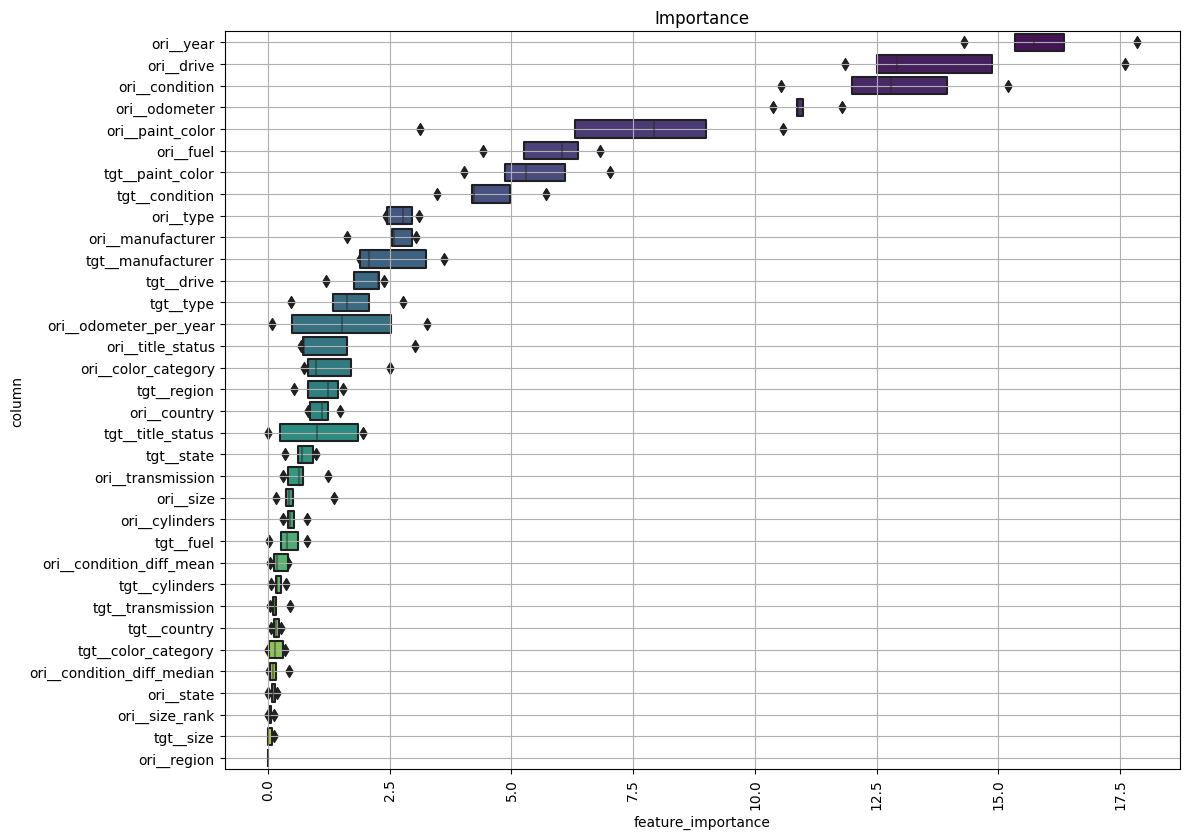

In [65]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [66]:
df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
train_df[train_df['odometer'] < 0]['odometer'].sum()